<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/cci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

# Disable warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize

# Config display
%config InlineBackend.figure_format = 'retina'

In [4]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/cci.csv')
df.columns = df.columns.str.replace(' ', '') #Remove blank space
df.head(5)

,Month,N,Aging,Aging12
0,1,13109,0,0
1,1,322,0,1
2,1,71,0,2
3,1,23,0,3
4,1,230,0,4


In [5]:
# Monthly transition matrix
totalMonth = df.groupby(['Month', 'Aging'], as_index = False, sort = False)['N'].sum().rename(columns = {'N': 'Total'})
df = pd.merge(df, totalMonth, on = ['Month', 'Aging'], how = 'left') #Avoid missing in some month
df['TransitionRate'] = df['N'] / df['Total']

# Average transition matrix
averageMatrix = df.groupby(['Aging', 'Aging12'], as_index = False)['N'].sum()
total = df.groupby(['Aging'], as_index = False)['N'].sum().rename(columns = {'N': 'Total'})
averageMatrix = pd.merge(averageMatrix, total, on = ['Aging'], how = 'left')
averageMatrix['TransitionRate'] = averageMatrix['N'] / averageMatrix['Total']

# Upper threshold
averageMatrix['CumDefault'] = averageMatrix.groupby(['Aging'])['TransitionRate'].cumsum()
averageMatrix['Survive'] = 1 - averageMatrix['CumDefault']
averageMatrix['Survive1'] = averageMatrix.groupby(['Aging'], sort = False)['Survive'].shift(1).fillna(0)
averageMatrix['Upper'] = norm.ppf(averageMatrix['Survive1'])

In [6]:
# Convert to numpy array
# N Array
nArray = df[df['Aging'] != 4] #Drop default at observation
nArray = nArray.groupby(['Month', 'Aging'], as_index = False)['N'].sum()
nArray = nArray['N'].to_numpy()
nArray = np.repeat(nArray, df['Aging'].max() + 1)
nArray = nArray.reshape(np.unique(df['Month']).shape[0], -1)

# Monthly array
monthlyArray = df[df['Aging'] != 4] #Drop default at observation
monthlyArray = pd.pivot_table(monthlyArray,
                              values = 'TransitionRate',
                              index = ['Month', 'Aging'],
                              columns = ['Aging12']).fillna(0) #Missing observation in month
monthlyArray = monthlyArray.to_numpy()
monthlyArray = monthlyArray.reshape(np.unique(df['Month']).shape[0], -1)

# Upper array
upperArray = averageMatrix[averageMatrix['Aging'] != 4] #Drop default at observation
upperArray = pd.pivot_table(upperArray,
                            values = 'Upper',
                            index = ['Aging'],
                            columns = ['Aging12']).fillna(0) #Missing observation
upperArray = upperArray.to_numpy()

In [7]:
# Credit cycle index (CCI)
# Define CCI Function
def creditCycleIndex(x):
  monthlyFitted = []
  
  for i in range(x.shape[0] - 1):
    fittedUpper = (upperArray - (np.sqrt(x[-1]) * x[i])) / np.sqrt(1 - x[-1])
    monthlyFitted.append(fittedUpper)
      
  monthlyFitted = np.vstack(monthlyFitted)

  # Fitted matrix
  cdfMonthly = [norm.cdf(monthlyFitted[0:, i]) for i in range(1, 5)] #Cumulative matrix
  
  fittedMatrix = np.stack((1 - cdfMonthly[0],
                           cdfMonthly[0] - cdfMonthly[1],
                           cdfMonthly[1] - cdfMonthly[2],
                           cdfMonthly[2] - cdfMonthly[3],
                           cdfMonthly[3]), axis = 1)

  fittedMatrix = fittedMatrix.reshape(x.shape[0] - 1, -1)
  
  # Error matrix
  errorMatrix = nArray * ((monthlyArray - fittedMatrix) ** 2) / (fittedMatrix * (1 - fittedMatrix))
  error = np.sum(errorMatrix) 
  return error

# Define minimize error
def findCCI(x):
  return creditCycleIndex(x)

# Define constraints
def constraint(x):
  return np.std(x[:-1]) - 1

In [8]:
# Initial guess
x0 = np.random.randn(monthlyArray.shape[0]) #Guess CCI
rho0 = 0.0001 #Set Rho close to 0
init = np.hstack((x0, rho0))

# Constraints
constraints = {'type': 'eq', 'fun': constraint}

# Set option for iteration
options = {'maxiter': 10000, 'disp': True} #Increase number of iteration

In [9]:
# Finding CCI
CCIOpt = minimize(findCCI, init, constraints = constraints, options = options)
CCIOpt

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3354.4796159276293
            Iterations: 61
            Function evaluations: 2717
            Gradient evaluations: 61


     fun: 3354.4796159276293
     jac: array([ 6.75964355e-02,  1.35498047e-02,  4.87670898e-02,  4.92858887e-02,
        6.93969727e-02,  6.50634766e-02,  9.55200195e-02,  6.98547363e-02,
        3.50341797e-02,  2.84729004e-02,  4.20837402e-02,  5.45654297e-02,
        1.81579590e-02,  1.42822266e-02,  2.28271484e-02, -2.34985352e-03,
        2.99072266e-03, -1.53198242e-02, -2.44140625e-02, -2.33764648e-02,
       -3.43627930e-02, -1.48620605e-02, -5.09643555e-03,  1.19018555e-03,
       -4.33349609e-03, -1.33361816e-02, -2.44445801e-02, -2.26440430e-02,
       -2.49023438e-02, -2.37731934e-02, -3.63464355e-02, -3.17077637e-02,
       -5.22155762e-02, -4.67834473e-02, -4.87060547e-02, -3.74755859e-02,
       -4.46777344e-02, -5.09948730e-02, -5.20324707e-02, -5.16052246e-02,
       -2.99890137e+00])
 message: 'Optimization terminated successfully.'
    nfev: 2717
     nit: 61
    njev: 61
  status: 0
 success: True
       x: array([ 1.86817973,  0.53704831,  1.4558568 ,  1.42952682,

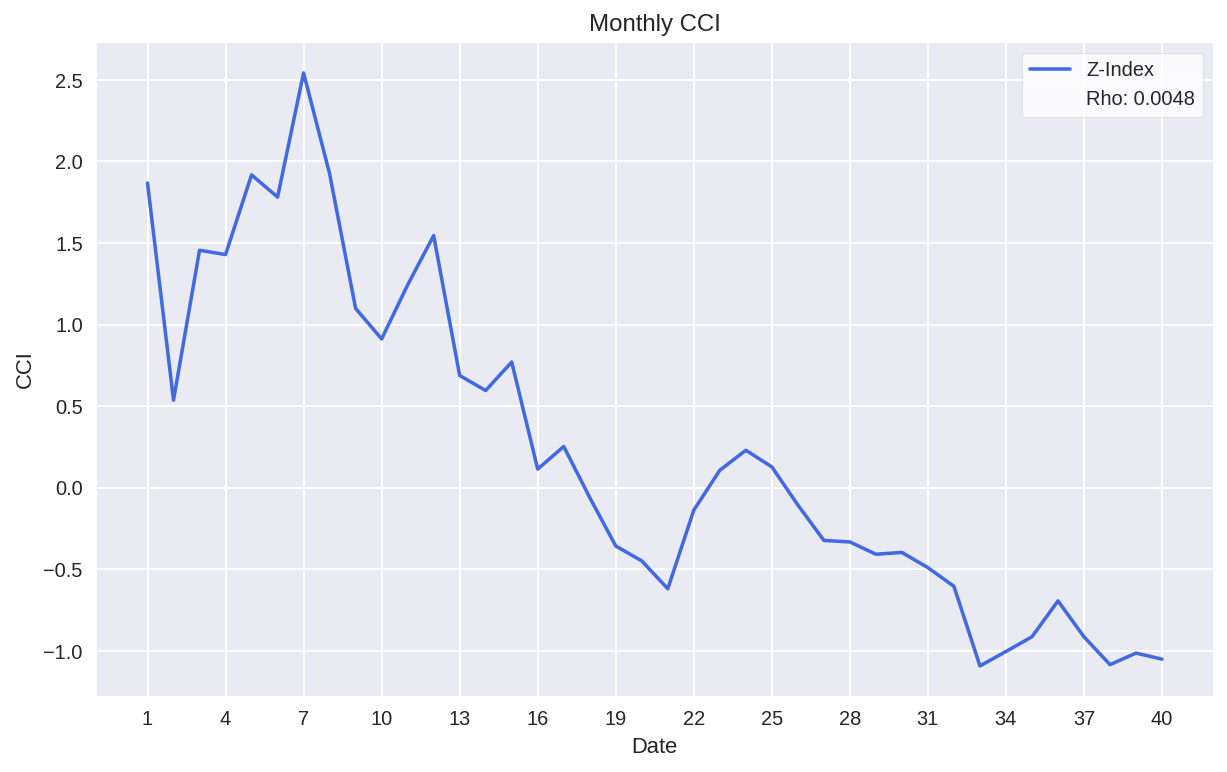

In [10]:
# Results
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Monthly CCI')
  plt.xlabel('Date')
  plt.ylabel('CCI')
  plt.plot(np.arange(1, CCIOpt.x[:-1].shape[0] + 1),
           CCIOpt.x[:-1], c = 'royalblue', label = 'Z-Index')
  plt.plot([], [], ' ', label = f'Rho: {CCIOpt.x[-1]:.4f}')
  plt.xticks(np.arange(1, CCIOpt.x[:-1].shape[0] + 1, 3))
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()